# TimeEvolvingMPO - Tutorial

The TimeEvolvingMPO library is currently under construction. This example serves merely as a placeholder for the tutorial to come. However, you can check that you can access the (almost) empty library by executing the `Say hi!` example below.

-------------------------------------------------
## Say hi!
This is just to check that you can access the tempo package.

In [1]:
import time_evolving_mpo as tempo

In [2]:
tempo.say_hi()


Hi there!
This is TimeEvolvingMPO version 0.0.1-1 speaking!



-------------------------------------------------
## Example A - The Minimal Example
ToDo: Explain what we do here

Import what we need:

In [3]:
import time_evolving_mpo as tempo
import numpy as np
import matplotlib.pyplot as plt

### The Bath

Define the physics of the bath:

In [4]:
wc = 4.0 
alpha = 0.3
temperature = 0.1
spectral_density = lambda w: 2*alpha*w*np.exp(w/wc) # this is an ohmic spectral density
coupling_operator = np.array([[1.0,0.0],[0.0,-1.0]]) # the coupling to the spin is the sigma z operator.

Create a `tempo.Bath` object to encapsulate this bath information:

In [5]:
bath_A = tempo.Bath(coupling_operator, spectral_density, temperature=temperature)

### The System

Define the system Hamiltonian:

In [6]:
epsilon = 1.0
Delta = 0.1
hamiltonian = np.array([[1.0,0.0],[0.0,-1.0]]) * epsilon/2.0 \
              + np.array([[0.0,1.0],[1.0,0.0]]) * Delta/2.0

Create a `tempo.System` object to encapsulate this system information:

In [7]:
system_A = tempo.System(hamiltonian)

### The Computation

Define the initial state as well as the start and end time:

In [8]:
initial_state = np.array([[1.0,0.0],[0.0,0.0]]) # start in the up-state
t_start_A = 0.0
t_end_A = 10.0

Create a `tempo.TempoSys` object:

In [9]:
tempo_sys_A = tempo.TempoSys(bath_A, system_A , initial_state, t_start_A, t_end_A)

Make the actual computation:

In [10]:
tempo_sys_A.compute()

Get a `tempo.Dynamics` object from `tempo_sys_A`:

In [11]:
dynamics_A = tempo_sys_A.get_dynamics()

Get expectation values for a specific operator:

In [12]:
sigma_z = np.array([[1.0,0.0],[0.0,-1.0]]) 
t_A, y_A = dynamics_A.get_expectations(sigma_z, real=True)

In [13]:
# cheat if the whole thing is not yet implemented
if t_A is NotImplemented or y_A is NotImplemented:
    t_A, y_A = np.array([0.0,0.1,0.2,0.3]), np.array([1.0,0.99,0.90,0.70]) 

Plot the results:

Text(0, 0.5, '$<\\sigma_z>$')

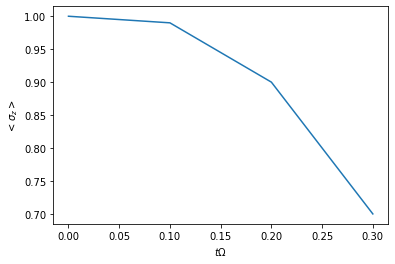

In [14]:
plt.plot(t_A, y_A)    
plt.xlabel(r'$t \Omega$')
plt.ylabel(r'$<\sigma_z>$')